In [34]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

## Question 5

In [35]:
default = pd.read_csv('../../data/default.csv', na_values=['?'])
default.dropna(axis=0, inplace=True)
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


### 15.a

In [36]:
X = default.loc[:, ['income', 'balance']]
y = pd.get_dummies(default['default'])['Yes']

default_logit = LogisticRegression(fit_intercept=True)
default_logit.fit(X, y)

default_logit.intercept_, default_logit.coef_

(array([-11.54046792]), array([[2.08089741e-05, 5.64710265e-03]]))

### 15.b

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=0.3, random_state=1)

In [38]:
def_logit = sm.Logit(y_train, X_train).fit()
def_logit.summary()

Optimization terminated successfully.
         Current function value: 0.078788
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Yes   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6997
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.4758
Time:                        13:44:11   Log-Likelihood:                -551.52
converged:                       True   LL-Null:                       -1052.0
Covariance Type:            nonrobust   LLR p-value:                4.249e-218
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8581      0.528    -22.477      0.000     -12.892     -10.824
income      2.223e-05      6e-06      3.707      0.000    1.05e-05     3.4e-05
balance        0.0059      0.000     21.078      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [39]:
predictions = def_logit.predict(X_test)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

In [40]:
from sklearn.metrics import accuracy_score

print(f'Misclassification Error: {1 - accuracy_score(y_test, predictions)}')

Misclassification Error: 0.024666666666666615


### 15.c

In [41]:
miss_class_err = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=0.7)
    def_logit = LogisticRegression(fit_intercept=True).fit(X_train, y_train)
    
    predictions = def_logit.predict(X_test)
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    
    error_rate = 1 - accuracy_score(y_test, predictions)
    miss_class_err.append(error_rate)
    print(f'Misclassification Error - {i+1}: {error_rate}')

Misclassification Error - 1: 0.026428571428571468
Misclassification Error - 2: 0.028857142857142803
Misclassification Error - 3: 0.0268571428571428


In [42]:
np.array(miss_class_err).mean()

0.027380952380952357

### 15.d

In [43]:
X = default.loc[:, ['income', 'balance', 'student']]
X = pd.get_dummies(X, columns=['student'])[['income', 'balance', 'student_Yes']]
y = pd.get_dummies(default['default'])['Yes']

In [44]:
# Including a dummy variable for student
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [45]:
def_logit2 = LogisticRegression(fit_intercept=True).fit(X_train, y_train)

predictions = def_logit2.predict(X_test)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

In [46]:
error_rate = 1 - accuracy_score(y_test, predictions)
print(f'Model with student dummy var. : {error_rate}')

Model with student dummy var. : 0.024333333333333318


In [47]:
# Not including a dummy variable for student
X_train, X_test, y_train, y_test = train_test_split(X.drop(['student_Yes'], axis=1), 
                                                    y, test_size=0.3, random_state=1)

def_logit3 = LogisticRegression(fit_intercept=True).fit(X_train, y_train)
predictions = def_logit3.predict(X_test)
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

error_rate = 1 - accuracy_score(y_test, predictions)
print(f'Model with student dummy var. : {error_rate}')

Model with student dummy var. : 0.024666666666666615


## Question 6

### 6.a

In [48]:
X = default.loc[:, ['income', 'balance']]
y = pd.get_dummies(default['default'])['Yes']

logit = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
logit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-11.5405,0.435,-26.544,0.000,-12.393,-10.688
income,2.081e-05,4.99e-06,4.174,0.000,1.1e-05,3.06e-05
balance,0.0056,0.000,24.835,0.000,0.005,0.006


### 6.b

In [49]:
def boot_fn(data, indices):
    X = sm.add_constant(data[['balance', 'income']].loc[indices])
    y = pd.get_dummies(data['default'].loc[indices])['Yes']
    
    logit = sm.Logit(y, X).fit(disp=False)
    return [logit.params['balance'], logit.params['income']]

In [50]:
np.random.seed(0)
indices = np.random.choice(default.index, size=len(default), replace=True)
boot_fn(default, indices)

[0.005799490373833469, 2.172836514900737e-05]

### 6.c

In [51]:
def boot(data, func, num_samples=1000):
    coef_income = []
    coef_balance = []
    for i in range(num_samples):
        indices = np.random.choice(default.index, size=len(default), replace=True)
        results = func(data, indices)
        coef_income.append(results[0])
        coef_balance.append(results[1])
    
    return np.array(coef_balance).std(), np.array(coef_income).std()

np.random.seed(0)
boot(default, boot_fn, 1000)

(4.713197793939106e-06, 0.00023616384027116337)

### 6.d

Estimated bootstrap standard errors are comparable to those obtained in section 6.b.

## Question 7

In [52]:
weekly = pd.read_csv('../../data/weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


### 7.a

In [53]:
X = sm.add_constant(weekly.loc[:, ['Lag1', 'Lag2']])
y = pd.get_dummies(weekly['Direction'])['Up']

In [54]:
logit = sm.Logit(y, X).fit(disp=False)
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                0.005335
Time:                        13:44:27   Log-Likelihood:                -744.11
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.01848
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2212      0.061      3.599      0.000       0.101       0.342
Lag1          -0.0387      0.026     -1.477      0.140      -0.090       0.013
Lag2           0.0602      0.027      2.270      0.023       0.008       0.112
==============================================================================
"""

### 7.b

In [55]:
logit2 = sm.Logit(y.loc[1:], X.loc[1:]).fit(disp=False)
logit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     Up   No. Observations:                 1088
Model:                          Logit   Df Residuals:                     1085
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                0.005387
Time:                        13:44:27   Log-Likelihood:                -743.26
converged:                       True   LL-Null:                       -747.29
Covariance Type:            nonrobust   LLR p-value:                   0.01785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2232      0.061      3.630      0.000       0.103       0.344
Lag1          -0.0384      0.026     -1.466      0.143      -0.090       0.013
Lag2           0.0608      0.027      2.291      0.022       0.009       0.113
==============================================================================
"""

### 7.c

In [56]:
prob = logit2.predict(X.loc[0])
prob[0] > 0.5

True

In [57]:
y.loc[0]

False

The model predicted that the direction of the first observation would be `Up`, but in reality, it was `Down`. Therefore, the model misclassified the first observation.

### 7.d

In [58]:
loocv_predict = np.array([])
for i in range(0, len(weekly)):
    X_new = X.drop(i, axis=0)
    y_new = y.drop(i, axis=0)
    
    logit = sm.Logit(y_new, X_new).fit(disp=False)
    prob = logit.predict(X.loc[i, :], y.loc[i])

    loocv_predict = np.append(loocv_predict, prob)

### 7.e

In [59]:
loocv_predict = (loocv_predict > 0.5)
np.mean(loocv_predict != y)

0.44995408631772266

In [60]:
weekly['Direction'].value_counts() / len(weekly['Direction'])

Direction
Up      0.555556
Down    0.444444
Name: count, dtype: float64

If we developed a model that always predicts the `direction` as `Down`, the test error would be approximately 0.44. This indicates that the model we have developed is not effective.

## Question 8

In [61]:
np.random.seed(1)
X = np.sort(np.random.randn(100))
y = X - 2 * X**2 + np.random.randn(100)

### 8.a

$$ y = X - 2X^2 + \epsilon $$

- n = 100
- p = 2

### 8.b

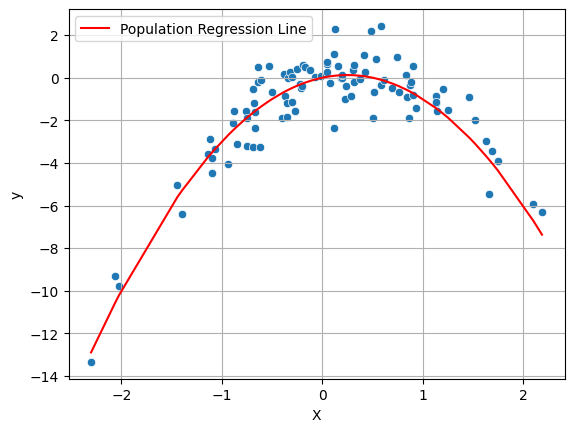

In [62]:
ax = sns.scatterplot(x=X, y=y)
ax.plot(X, X-2*X**2, color='r', label='Population Regression Line')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.grid()
ax.legend()

$$ f(X) = X - 2X^2 $$
$$ \implies X(1 - 2X) $$
$$ \implies f(X) = 0 \iff X \in {0, 0.5} $$

---

$$ f(X) = X - 2X^2 $$
$$ \implies f'(X) = 1 - 4X $$
$$ \implies f'(X) = 0 \iff X = 0.25 $$

--- 

We have $ f''(0.25) = -4 \lt 0 $, so 0.25 is a maximum.

### 8.c

In [63]:
from sklearn.model_selection import cross_val_score

def poly_loocv(data, degree):
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lm = LinearRegression()
    
    cv_score = cross_val_score(lm, poly.fit_transform(data['x'][:, np.newaxis]), data['y'],
                                     scoring='neg_mean_squared_error', cv=len(data['x']))
    
    return -np.mean(cv_score)

In [64]:
df = pd.DataFrame({ 'y': y, 'x': X })

In [65]:
# Set random seed for reproducibility
np.random.seed(10)

# Define the poly_loocv function
def poly_loocv(data, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lm = LinearRegression()
    # Convert Series to NumPy array and reshape to 2D
    X = data['x'].to_numpy()[:, np.newaxis]
    cv_score = cross_val_score(lm, poly.fit_transform(X), data['y'],
                              scoring='neg_mean_squared_error', cv=len(data['x']))
    return -np.mean(cv_score)

# Run LOOCV for polynomial degrees 1 to 4
loocv_results = [poly_loocv(df, deg) for deg in range(1, 5)]
loocv_results

[5.90663789467059, 0.8889974749237376, 0.9078496663524078, 0.933425454661212]

Text(0.5, 0, 'Polynomial Order')

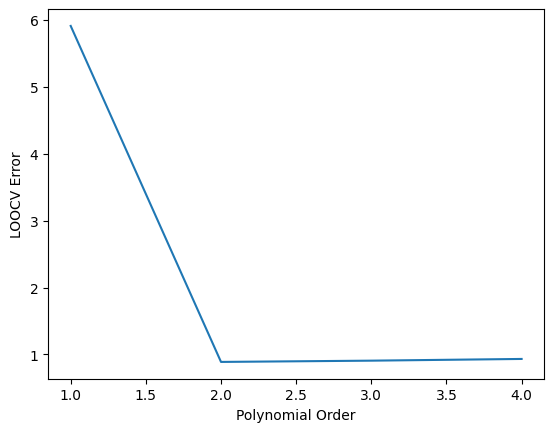

In [66]:
plt.plot(range(1,5), loocv_results)
plt.ylabel('LOOCV Error')
plt.xlabel('Polynomial Order')

### 8.d

In [67]:
np.random.seed(405)
loocv_results = [poly_loocv(df, deg) for deg in range(1, 5)]
loocv_results

[5.90663789467059, 0.8889974749237376, 0.9078496663524078, 0.933425454661212]

Text(0.5, 0, 'Polynomial Order')

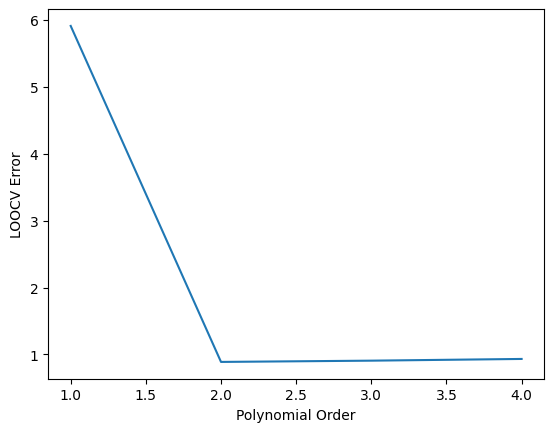

In [68]:
plt.plot(range(1,5), loocv_results)
plt.ylabel('LOOCV Error')
plt.xlabel('Polynomial Order')

We get the same results. This is because LOOCV does not involve any randomness. Unlike other cross-validation methods, there is only one way to calculate the LOOCV error: 

- Leave one observation out as the test set
- Train the model on the remaining set (the training set)
- Evaluate the model on the test set
- Repeat this process n times, until each observation has been used as a test set once
- Average these n errors to obtain the test error estimate.

### 8.e

The LOOCV analysis reveals that the second order polynomial has the smallest error. This finding is consistent with our previous observations in section (a), where we identified that the model has 2 roots and one maximum point at 0.25. Therefore, we would expect a quadratic relationship between X and y, which is confirmed by the LOOCV analysis.

### 8.f

In [69]:
df['x_2'] = X**2
df['x_3'] = X**3
df['x_4'] = X**4
df.head()

,y,x,x_2,x_3,x_4
0,-13.342828,-2.301539,5.297080,-12.191435,28.059060
1,-9.323992,-2.060141,4.244180,-8.743607,18.013062
2,-9.797305,-2.022201,4.089298,-8.269383,16.722356
3,-5.021465,-1.444114,2.085465,-3.011648,4.349163
4,-6.391812,-1.396496,1.950202,-2.723450,3.803288


In [70]:
def stat_significance(df, degree):
    X = sm.add_constant(df.loc[:, ['x', 'x_2', 'x_3', 'x_4']])
    y = df['y']
    
    lm = sm.OLS(y, X.loc[:, 'const':f'x_{degree}']).fit()
    print(f'Degree: {degree}')
    print(lm.summary().tables[1])
    print('')

In [71]:
for i in range(1, 5):
    stat_significance(df, i)

Degree: 1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4165      0.234     -6.048      0.000      -1.881      -0.952
x              0.9171      0.264      3.474      0.001       0.393       1.441

Degree: 2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0787      0.114      0.689      0.492      -0.148       0.305
x              1.1417      0.106     10.799      0.000       0.932       1.352
x_2           -1.9167      0.084    -22.787      0.000      -2.084      -1.750

Degree: 3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0792      0.115      0.689      0.492      -0.149       0.307
x              1.154

## Question 9

In [72]:
boston = pd.read_csv('../../data/boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### 9.a-b

In [73]:
# sample mean = total x / sample size
# standard error = sample std / sqrt(sample size)

medv = boston.medv
mean = np.mean(medv)
se = np.std(medv) / len(medv)**0.5

mean, se

(22.532806324110677, 0.4084569346972866)

### 9.c

In [74]:
def boot_sample(df, col, func):
    indices = np.random.choice(df.index, size=len(df), replace=True)
    return func(df[col].loc[indices])

def boot(df, col, func, num_samples=1000):
    boot_results = []
    for i in range(num_samples):
        boot_results.append(boot_sample(df, col, func))
    return scipy.std(boot_results, axis=0)

boot_se = boot(boston, 'medv', np.mean)
boot_se

0.4132684430065484

The standard error value estimated by bootstrap method is really close to our previous estimation.

### 9.d

In [75]:
lower_bound = mean - 2*boot_se
upper_bound = mean + 2*boot_se
[lower_bound, upper_bound]

[21.70626943809758, 23.359343210123775]

In [76]:
results = scipy.stats.ttest_1samp(medv, popmean=np.mean(medv))
results.confidence_interval()

ConfidenceInterval(low=21.729528014578595, high=23.33608463364276)

The confidence interval estimates are almost the same.

### 9.e

In [77]:
median = np.median(medv)
median

21.2

### 9.f

In [78]:
boot_median_se = boot(boston, 'medv', np.median)
boot_median_se

0.3787876845938893

### 9.g

In [79]:
mu_10_quantile = np.quantile(medv, q=0.1)
mu_10_quantile

12.75

### 9.h

In [80]:
from functools import partial
mu_01q_se = boot(boston, 'medv', partial(np.quantile, q=0.1))
mu_01q_se

0.5025877013019717

The mean of the tenth percentile is more variable compared to the mean of the median, as there are much fewer values in this small segment of the population.

<Axes: xlabel='medv', ylabel='Count'>

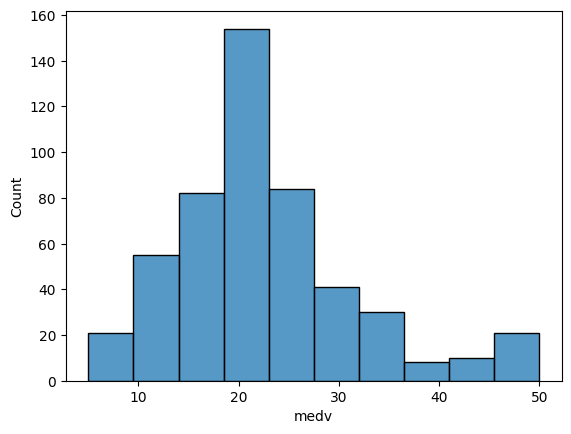

In [81]:
sns.histplot(x='medv', data=boston, bins=10)